In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
# imported libraries

In [4]:
# #clean per-capita-meat-type.csv
# import pandas as pd

# meat_df = pd.read_csv("datasets/original datasets/per-capita-meat-type.csv")
# codes_df = pd.read_csv("datasets/codes.csv")

# merged = pd.merge(meat_df, codes_df, left_on="Code", right_on="alpha-3", how="left")

# filtered = merged[merged["region"].isin(["Asia", "Europe"])]

# latest = filtered.sort_values("Year").groupby("Code").tail(1)

# meat_columns = [col for col in latest.columns if col.startswith("Meat")]
# latest["Total_Meat_kg_per_capita"] = latest[meat_columns].sum(axis=1)

# final_df = latest[["Entity", "Code", "Year", "region", "Total_Meat_kg_per_capita"] + meat_columns]

# final_df.to_csv("asia_europe_meat_consumption.csv", index=False)

# print(final_df["region"].value_counts())


In [5]:
# What we are going to do is use bootstrap sampling on the correlation between meat consumption and michlein star count.
# The rationale here is as such:
# Each COUNTRY has two VALUES. These VALUES are MEAT CONSUMPTION and MICHELIN COUNT (this can be either count of restaurants or count of stars.)
# We divide the two groups of countries into ASIAN and EUROPEAN.

# Why our research is relevant
---
There is always the debate in diet of meats versus vegetables, and we want to find out if they really are mutually exclusive. We also want to analyse the trends in meat and vegetable consumption over the years, and how they play off of each other.

In [6]:
# Import relevant datasets

df_meats = pd.read_csv('datasets/per-capita-meat-type.csv')
df_vegs = pd.read_csv('datasets/vegetable-consumption-per-capita.csv')

# Replace long column names with ones that are more easy to access
df_meats = df_meats.rename(columns={
    'Meat, poultry | 00002734 || Food available for consumption | 0645pc || kilograms per year per capita': 'Poultry',
    'Meat, beef and buffalo | 00002731 || Food available for consumption | 0645pc || kilograms per year per capita': 'BeefBuffalo',
    'Meat, sheep and goat | 00002732 || Food available for consumption | 0645pc || kilograms per year per capita': 'SheepGoat',
    'Meat, pig | 00002733 || Food available for consumption | 0645pc || kilograms per year per capita': 'Pig',
    'Meat, Other | 00002735 || Food available for consumption | 0645pc || kilograms per year per capita': 'OtherMeat',
    'Fish and seafood | 00002960 || Food available for consumption | 0645pc || kilograms per year per capita': 'Seafood'
})

# Find total consumption
df_meats['totalconsumption'] = df_meats[['Poultry', 'BeefBuffalo', 'SheepGoat', 'Pig', 'OtherMeat', 'Seafood']].sum(axis=1, skipna=True)

df_vegs = df_vegs.rename(columns={
    'Vegetables | 00002918 || Food available for consumption | 0645pc || kilograms per year per capita': 'Vegetables'
})

# Compensate for muslim countries which may not have info for pigs.
df_meats['Pig'] = df_meats['Pig'].fillna(0)

print(df_meats.head())
print(df_vegs.head())

        Entity Code  Year   Poultry  BeefBuffalo  SheepGoat  Pig  OtherMeat  \
0  Afghanistan  AFG  1961  0.612220     4.664536   7.949147  0.0   0.826012   
1  Afghanistan  AFG  1962  0.641587     4.870231   7.699047  0.0   0.855450   
2  Afghanistan  AFG  1963  0.641828     4.920679   7.867252  0.0   1.040539   
3  Afghanistan  AFG  1964  0.651754     4.893021   8.122609  0.0   0.982495   
4  Afghanistan  AFG  1965  0.681102     4.855283   8.406744  0.0   1.031383   

    Seafood  totalconsumption  
0  0.029153         14.081069  
1  0.029163         14.095478  
2  0.029174         14.499472  
3  0.029183         14.679062  
4  0.029190         15.003702  
        Entity Code  Year  Vegetables
0  Afghanistan  AFG  1961   35.712856
1  Afghanistan  AFG  1962   36.424660
2  Afghanistan  AFG  1963   37.799760
3  Afghanistan  AFG  1964   39.076070
4  Afghanistan  AFG  1965   39.727703


In [7]:
# EDA
# What is the data we will need to be able to effectively answer the Q?
# Filter by current data. Get some summary statistics.
# Get histogram of meat and veg in 2022/2024.
# Get ECDF of meat and veg in 2022/2024.

# --------------------------------- Histogram -------------------------------- #
# For meat
# For all countries, so we should filter by entries that have a code.

# Calculate total meat

# Keep only rows for year 2022
meat_2022 = df_meats[df_meats['Year'] == 2022]

# Create a code filter for european countries
eu_codes = [
    'AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'DEU', 'GRC', 'HUN', 'IRL', 'ITA',
    'LVA', 'LTU', 'LUX', 'MLT', 'NLD', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE',
    'ALB', 'AND', 'ARM', 'BLR', 'BIH', 'FRO', 'GEO', 'GIB', 'ISL', 'IMN', 'XKX', 'LIE', 'MKD', 'MDA', 'MCO',
    'MNE', 'NOR', 'RUS', 'SMR', 'SRB', 'CHE', 'TUR', 'UKR', 'GBR', 'VAT'
]


# Create a code filter for asian countries
ap_codes = [
    'AFG', 'ARM', 'AZE', 'BHR', 'BGD', 'BTN', 'IOT', 'BRN',
    'KHM', 'CHN', 'CCK', 'GEO', 'HKG', 'IND', 'IDN', 'IRN',
    'IRQ', 'ISR', 'JPN', 'JOR', 'KAZ', 'KWT', 'KGZ', 'LAO',
    'LBN', 'MAC', 'MYS', 'MDV', 'MNG', 'MMR', 'NPL', 'PRK',
    'OMN', 'PAK', 'PSE', 'PHL', 'QAT', 'SAU', 'SGP', 'KOR',
    'LKA', 'SYR', 'TWN', 'TJK', 'THA', 'TUR', 'TKM', 'ARE',
    'UZB', 'VNM', 'YEM'
]

# Filter
meat_2022_eu = meat_2022[meat_2022['Code'].isin(eu_codes)]
meat_2022_ap = meat_2022[meat_2022['Code'].isin(ap_codes)]

# Do the same for vegetables
veg_2022 = df_vegs[df_vegs['Year'] == 2022]

veg_2022_eu = veg_2022[veg_2022['Code'].isin(eu_codes)]
veg_2022_ap = veg_2022[veg_2022['Code'].isin(ap_codes)]

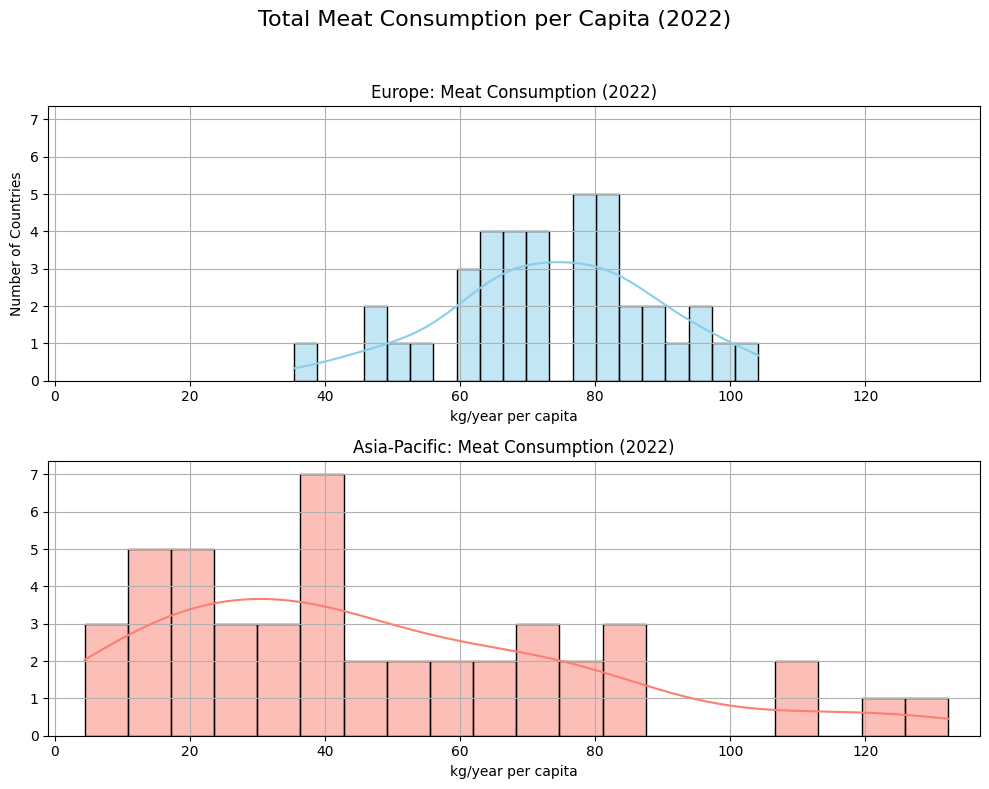

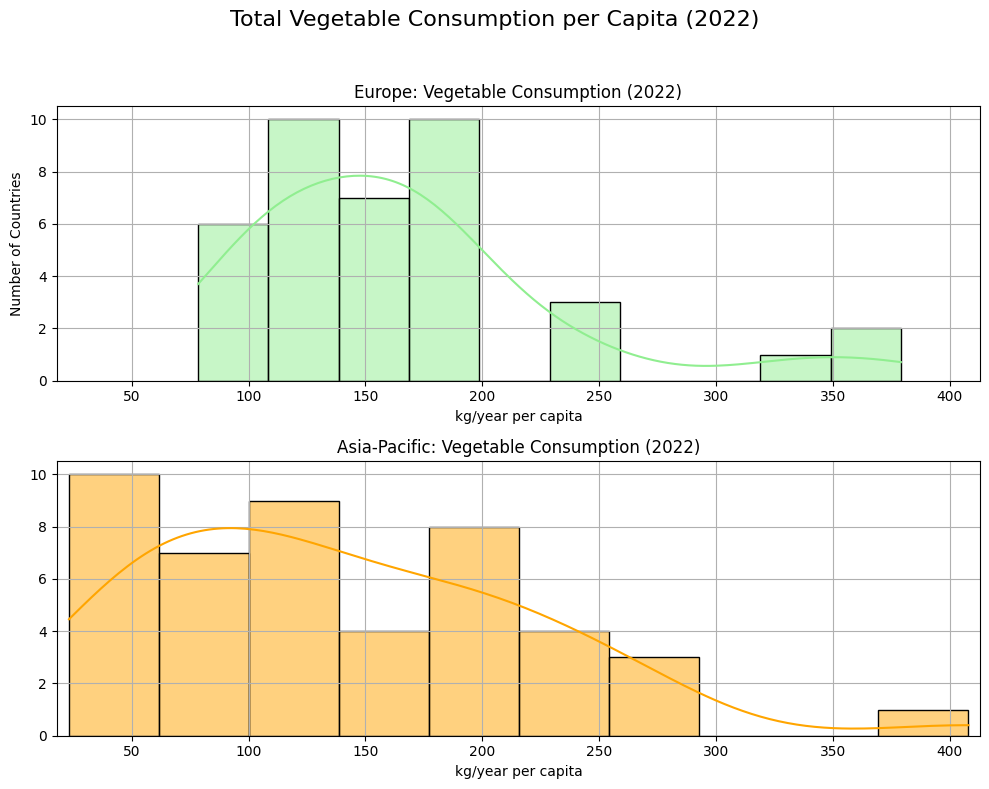

In [1]:
#This is the refactored code for Tuns eda, it uses merged_meat_fruit_veg.csv

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# LOAAAAAAAAAADDDDDDDDDDDDDDDDD
merged_df = pd.read_csv("datasets/merged_meat_fruit_veg.csv")

# Filter data for twozerotwotwo
merged_2022 = merged_df[merged_df['Year'] == 2022]

# seperate data by region
europe_data = merged_2022[merged_2022['region'] == 'Europe']
asia_data = merged_2022[merged_2022['region'] == 'Asia']

#  Meat Consumption Histogram  #
# Get combined min and max for x-axis
min_x_meat = min(europe_data['Total_Meat_kg_per_capita'].min(), asia_data['Total_Meat_kg_per_capita'].min())
max_x_meat = max(europe_data['Total_Meat_kg_per_capita'].max(), asia_data['Total_Meat_kg_per_capita'].max())
xlim_meat = (int(min_x_meat) - 5, int(max_x_meat) + 5)

# Set up subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharey=True)

# Europe histogram
sns.histplot(europe_data['Total_Meat_kg_per_capita'], color='skyblue', kde=True, bins=20, ax=axs[0])
axs[0].set_title('Europe: Meat Consumption (2022)')
axs[0].set_xlabel('kg/year per capita')
axs[0].set_ylabel('Number of Countries')
axs[0].set_xlim(xlim_meat)
axs[0].grid(True)

# Asia-Pacific histogram
sns.histplot(asia_data['Total_Meat_kg_per_capita'], color='salmon', kde=True, bins=20, ax=axs[1])
axs[1].set_title('Asia-Pacific: Meat Consumption (2022)')
axs[1].set_xlabel('kg/year per capita')
axs[1].set_ylabel('')
axs[1].set_xlim(xlim_meat)
axs[1].grid(True)

fig.suptitle('Total Meat Consumption per Capita (2022)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Vegetable Consumption Histogram  #
# Get combined min and max for x-axis
min_x_veg = min(europe_data['Vegetables_kg_per_capita'].min(), asia_data['Vegetables_kg_per_capita'].min())
max_x_veg = max(europe_data['Vegetables_kg_per_capita'].max(), asia_data['Vegetables_kg_per_capita'].max())
xlim_veg = (int(min_x_veg) - 5, int(max_x_veg) + 5)

# Set up side-by-side plots
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharey=True)

# Europe histogram
sns.histplot(europe_data['Vegetables_kg_per_capita'], color='lightgreen', kde=True, bins=10, ax=axs[0])
axs[0].set_title('Europe: Vegetable Consumption (2022)')
axs[0].set_xlabel('kg/year per capita')
axs[0].set_ylabel('Number of Countries')
axs[0].set_xlim(xlim_veg)
axs[0].grid(True)

# Asia-Pacific histogram
sns.histplot(asia_data['Vegetables_kg_per_capita'], color='orange', kde=True, bins=10, ax=axs[1])
axs[1].set_title('Asia-Pacific: Vegetable Consumption (2022)')
axs[1].set_xlabel('kg/year per capita')
axs[1].set_ylabel('')
axs[1].set_xlim(xlim_veg)
axs[1].grid(True)


fig.suptitle('Total Vegetable Consumption per Capita (2022)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [2]:
#This is what i used to merge the datasets, not rlly needed anymore but here it is for reference
# import pandas as pd

# # Load datasets
# meat_df = pd.read_csv("datasets/asia_europe_meat_consumption.csv")
# fruit_df = pd.read_csv("datasets/fruit-consumption-per-capita.csv")
# veg_df = pd.read_csv("datasets/vegetable-consumption-per-capita.csv")

# # Rename columns for clarity
# fruit_df = fruit_df.rename(columns={
#     "Fruit | 00002919 || Food available for consumption | 0645pc || kilograms per year per capita": "Fruit_kg_per_capita"
# })
# veg_df = veg_df.rename(columns={
#     "Vegetables | 00002918 || Food available for consumption | 0645pc || kilograms per year per capita": "Vegetables_kg_per_capita"
# })

# # Merge datasets on Entity, Code, and Year
# merged_df = meat_df.merge(
#     fruit_df[["Entity", "Code", "Year", "Fruit_kg_per_capita"]],
#     on=["Entity", "Code", "Year"],
#     how="inner"
# ).merge(
#     veg_df[["Entity", "Code", "Year", "Vegetables_kg_per_capita"]],
#     on=["Entity", "Code", "Year"],
#     how="inner"
# )

# # Check for missing values
# print(merged_df.isnull().sum())

# # Save the merged dataset
# merged_df.to_csv("datasets/merged_meat_fruit_veg.csv", index=False)

# # Display the first few rows of the merged dataset
# print(merged_df.head())

Mean meat consumption per capita in Europe is : 73.8 kg/capita/year
Mean meat consumption per capita in Asia is : 47.52 kg/capita/year
Difference of mean meat consumption between EU and Asia is : 26.28
95% of differences of means sampled lie between -12.54 and 12.22
One-sided p-value (EU > Asia): 0.0000
Two-sided p-value:             0.0000


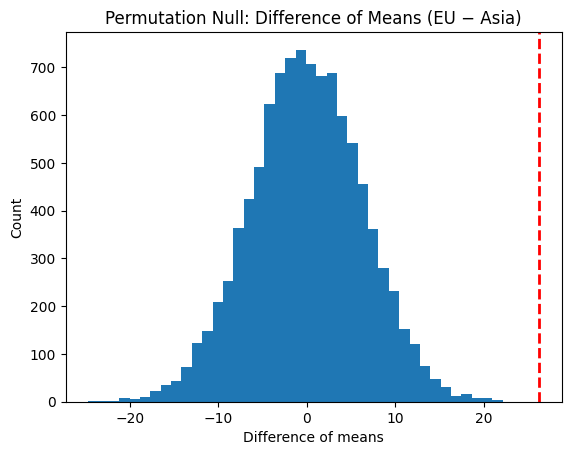

In [19]:
# Let's do hypothesis testing to see if European countries really do eat more meat!
# The way this will work is that for each country there is a meat consumed per capita value.

# Function to find diff of means as this will be important
def diff_of_means(data1, data2) :
    return np.mean(data1) - np.mean(data2)

eu_meat = europe_data['Total_Meat_kg_per_capita']
ap_meat = asia_data['Total_Meat_kg_per_capita']

# We first find the mean meat consumption for the EU and AP.
# Then, we find the observed difference in means.
eu_mean_meat = np.mean(eu_meat)
ap_mean_meat = np.mean(ap_meat)
print(f"Mean meat consumption per capita in Europe is : {np.round(eu_mean_meat, 2)} kg/capita/year")
print(f"Mean meat consumption per capita in Asia is : {np.round(ap_mean_meat, 2)} kg/capita/year")
obsvd_diff_of_means = diff_of_means(eu_meat, ap_meat)
print(f"Difference of mean meat consumption between EU and Asia is : {abs(np.round(obsvd_diff_of_means, 2))}")

# Now, let's do some bootstrap resampling.
# Concatenate the two arrays of EU meat consumption and AP meat consumption.
# Initialise an array to store the differences in means
concat_meat = np.concatenate((eu_meat, ap_meat))
meandiffs = []
samples = 10000

# Repeat the following 10k times:
# Shuffle the new array, then label the first X as "EU" and the rest as "AP"
# Find means for each, and find the difference.
# Append the difference to the diff of means array
for i in range(samples) :
    np.random.shuffle(concat_meat)
    shuffle_EU = concat_meat[:len(eu_meat)]
    shuffle_AP = concat_meat[len(eu_meat):]
    
    shuffle_diff_of_means = diff_of_means(shuffle_EU, shuffle_AP)
    meandiffs.append(shuffle_diff_of_means)

# Now, we should have 10k diff's of means
# Find 95% CI for the diff of means
conf_int_means = np.percentile(meandiffs, (2.5, 97.5))
print(f"95% of differences of means sampled lie between {conf_int_means[0]:.2f} and {conf_int_means[1]:.2f}")
# Draw histogram of diff of means, and show the observed as a vertical line

# p-values
# One-sided (EU > Asia): proportion of null diffs >= observed
p_val_one_sided = np.mean(meandiffs >= obsvd_diff_of_means)
# Two-sided: extremeness by absolute value
p_val_two_sided = np.mean(np.abs(meandiffs) >= abs(obsvd_diff_of_means))

print(f"One-sided p-value (EU > Asia): {p_val_one_sided:.4f}")
print(f"Two-sided p-value:             {p_val_two_sided:.4f}")

# Plot null distribution with observed diff
plt.figure()
plt.hist(meandiffs, bins=40)
plt.axvline(obsvd_diff_of_means, linestyle='--', linewidth=2, color='red')
plt.title("Permutation Null: Difference of Means (EU − Asia)")
plt.xlabel("Difference of means")
plt.ylabel("Count")
plt.show()


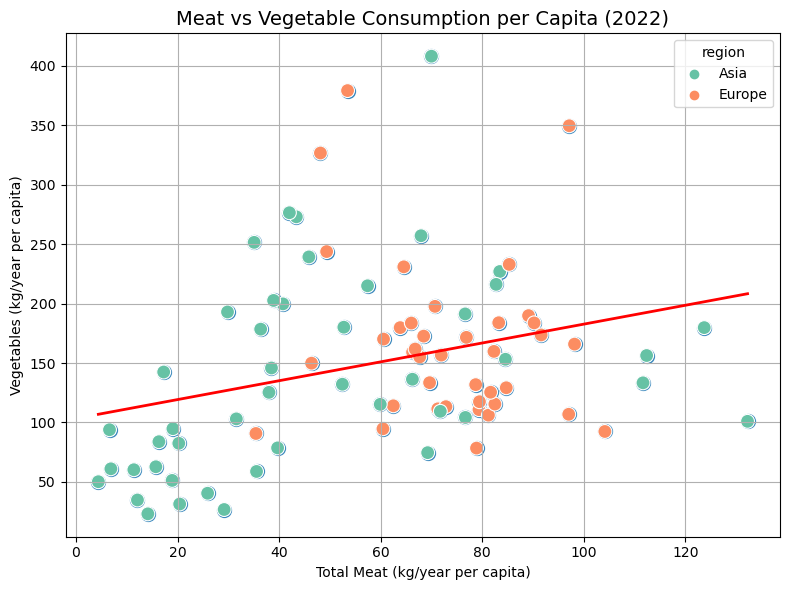

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
merged_df = pd.read_csv("datasets/merged_meat_fruit_veg.csv")

# Filter for 2022 data
merged_2022 = merged_df[merged_df['Year'] == 2022]

# Create scatterplot with regression line
plt.figure(figsize=(8, 6))
sns.regplot(
    data=merged_2022,
    x='Total_Meat_kg_per_capita',
    y='Vegetables_kg_per_capita',
    scatter_kws={'s': 100, 'alpha': 0.8},  # point size & transparency
    line_kws={'color': 'red', 'lw': 2},    # regression line style
    ci=None,                               # no confidence band
    marker='o'
)

# Overlay points with color by region
sns.scatterplot(
    data=merged_2022,
    x='Total_Meat_kg_per_capita',
    y='Vegetables_kg_per_capita',
    hue='region',
    palette='Set2',
    s=100,
    legend=True
)

plt.title('Meat vs Vegetable Consumption per Capita (2022)', fontsize=14)
plt.xlabel('Total Meat (kg/year per capita)')
plt.ylabel('Vegetables (kg/year per capita)')
plt.grid(True)
plt.tight_layout()
plt.show()

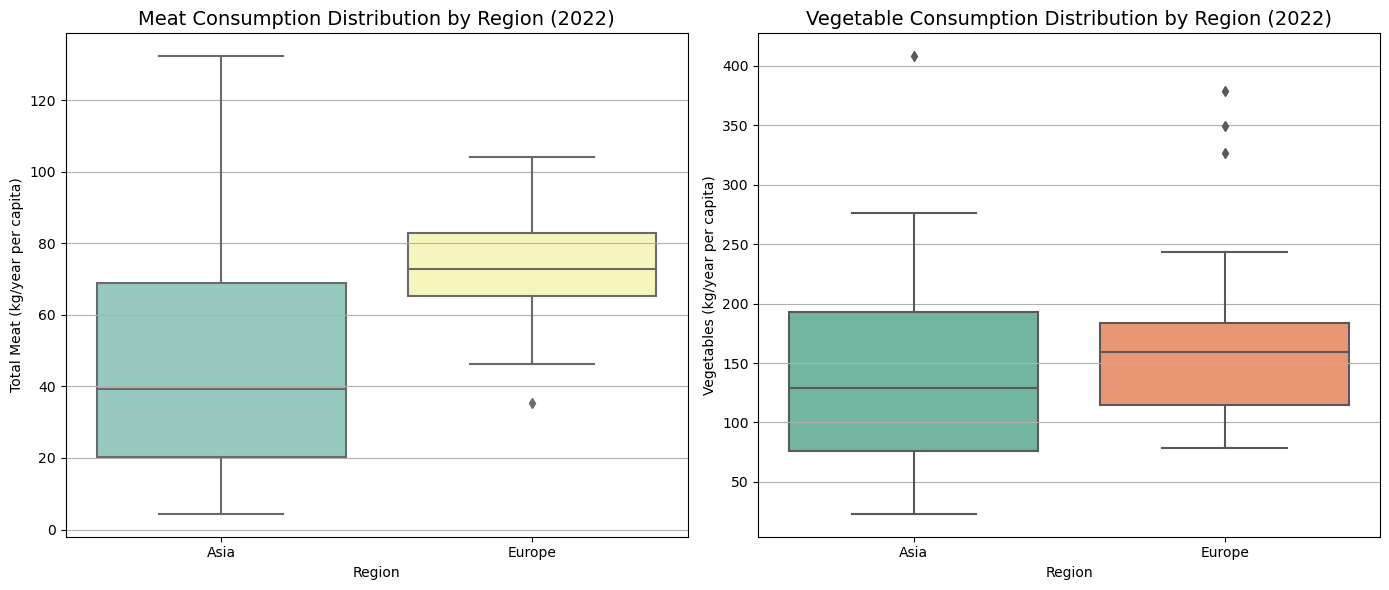

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
merged_df = pd.read_csv("datasets/merged_meat_fruit_veg.csv")

# Set figure size for two plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# Box plot for Meat consumption
sns.boxplot(
    data=merged_2022,
    x='region',
    y='Total_Meat_kg_per_capita',
    palette='Set3',
    ax=axs[0]
)
axs[0].set_title('Meat Consumption Distribution by Region (2022)', fontsize=14)
axs[0].set_xlabel('Region')
axs[0].set_ylabel('Total Meat (kg/year per capita)')
axs[0].grid(True, axis='y')

# Box plot for Vegetable consumption
sns.boxplot(
    data=merged_2022,
    x='region',
    y='Vegetables_kg_per_capita',
    palette='Set2',
    ax=axs[1]
)
axs[1].set_title('Vegetable Consumption Distribution by Region (2022)', fontsize=14)
axs[1].set_xlabel('Region')
axs[1].set_ylabel('Vegetables (kg/year per capita)')
axs[1].grid(True, axis='y')

plt.tight_layout()
plt.show()

# Question X Analysis
---
As can be seen, the observed difference in means between the mean meat consumption and Europe and that of Asia is far outside of the 95% confidence interval, with a p-value of 0.0001 or less. This shows that there is a definite difference between the distribution of meat consumption per capita in Europe and Asia, and that this is not a product of random chance. 